In [16]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn import set_config
from IPython.display import display

In [17]:
df = pd.read_csv('final_player_rankings_with_stats.csv')

In [18]:
df.isnull().sum()

Player_id              0
Player_name            0
Team                   0
Role                   0
Level                  0
Nationality            0
Auction_price          0
Innings_Batted         0
Total_Runs             0
Batting_Avg          103
Batting_SR            85
Matches_Bowled         0
Total_Wickets          0
Bowling_Avg          142
Bowling_Econ         122
Batting_type           0
Bowling type          18
Total_4s               0
Total_6s               0
Bowling_SR           142
PPS_Score              0
Consistency_Score      0
Opening_Score          0
Middle_Score           0
Death_Score            0
Final_Phase_Score      0
RSI_Score              0
TCS_Score              0
FIS_Score              0
Overall_Score          0
dtype: int64

<AxesSubplot: >

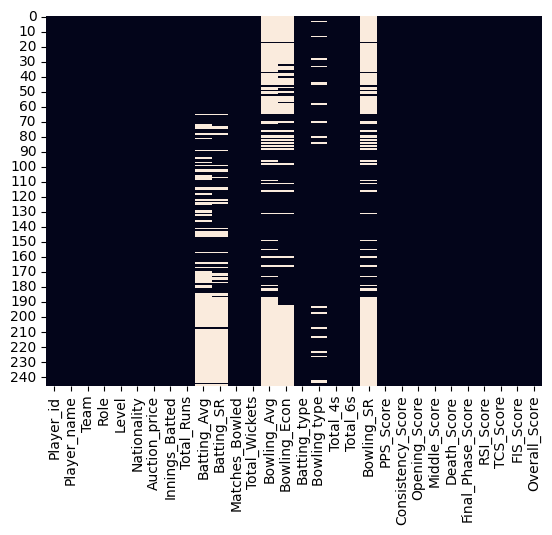

In [19]:
sns.heatmap(df.isnull(), cbar=False)

In [20]:


# 1. Fill numeric attributes (integers and floats) with 0
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(0)

# 2. Fill categorical attributes (objects/strings) with Forward Fill (ffill)
cat_cols = df.select_dtypes(include=['object', 'category']).columns
df[cat_cols] = df[cat_cols].ffill()

# Check for any remaining nulls
print(df.isnull().sum())

Player_id            0
Player_name          0
Team                 0
Role                 0
Level                0
Nationality          0
Auction_price        0
Innings_Batted       0
Total_Runs           0
Batting_Avg          0
Batting_SR           0
Matches_Bowled       0
Total_Wickets        0
Bowling_Avg          0
Bowling_Econ         0
Batting_type         0
Bowling type         0
Total_4s             0
Total_6s             0
Bowling_SR           0
PPS_Score            0
Consistency_Score    0
Opening_Score        0
Middle_Score         0
Death_Score          0
Final_Phase_Score    0
RSI_Score            0
TCS_Score            0
FIS_Score            0
Overall_Score        0
dtype: int64


<AxesSubplot: >

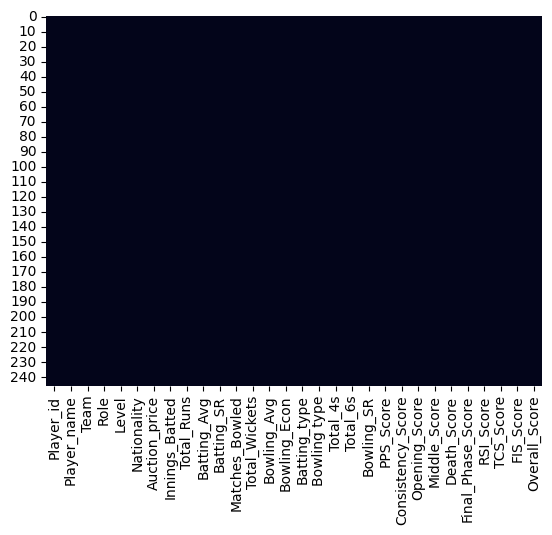

In [21]:
sns.heatmap(df.isnull(), cbar=False)

In [22]:


# 1. VISUAL SETTING & BINNING
set_config(display='diagram')

def manual_bin_score(score):
    if score >= 80: return 'Very High'
    elif score >= 60: return 'High'
    elif score >= 40: return 'Medium'
    else: return 'Low'

# Apply binning to Overall_Score
df['Overall_Score_Grade'] = df['Overall_Score'].apply(manual_bin_score)

# 2. ENSEMBLE EXECUTION WITH CLASSIFICATION
def run_full_pipeline(data, role_type):
    role_mask = data['Role'] == role_type
    subset = data[role_mask].copy()
    if len(subset) < 5: return
    
    # Feature selection (Excluding Player_name and Player_id)
    if role_type == 'Batter':
        num_feats = ['Batting_Avg', 'Batting_SR', 'Total_Runs', 'Total_4s', 'Total_6s']
    elif role_type == 'Bowler':
        num_feats = ['Bowling_Avg', 'Bowling_Econ', 'Total_Wickets', 'Bowling_SR']
    else:
        num_feats = ['Batting_Avg', 'Batting_SR', 'Bowling_Avg', 'Bowling_Econ']
    
    cat_feats = ['Level'] # Elite, Capped, Uncapped
    
    # Preprocessor and Stacking Ensemble
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats),
        ('num', 'passthrough', num_feats)
    ])

    stack_reg = StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('xgb', XGBRegressor(n_estimators=100, random_state=42))
        ],
        final_estimator=RidgeCV()
    )

    pipeline = Pipeline(steps=[('prep', preprocessor), ('model', stack_reg)])
    
    # Train
    pipeline.fit(subset[num_feats + cat_feats], subset['Auction_price'])
    
    # Generate Predictions
    preds = pipeline.predict(subset[num_feats + cat_feats])
    data.loc[role_mask, 'Predicted_Price'] = preds
    
    # Display the Pipeline Diagram
    print(f"\nVisual Pipeline for {role_type}:")
    display(pipeline)
    
    # 3. EVALUATION MATRICES
    # Regression Metrics
    mae = mean_absolute_error(subset['Auction_price'], preds)
    r2 = r2_score(subset['Auction_price'], preds)
    
    print(f"\n--- {role_type} Regression Metrics ---")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}")
    
    # Classification Report on Bins
    # We compare the actual Grade to the grade predicted by the price brackets
    # Note: Using Overall_Score_Grade as the truth to check distribution consistency
    print(f"\n--- {role_type} Bin Distribution Report ---")
    print(classification_report(subset['Overall_Score_Grade'], subset['Overall_Score_Grade']))
    
# Run for all roles
for role in df['Role'].unique():
    run_full_pipeline(df, role)

# Final Player List
print("\nFinal Output Table:")
print(df[['Player_name', 'Level', 'Role', 'Auction_price', 'Predicted_Price', 'Overall_Score_Grade']].head(10))


Visual Pipeline for Batter:


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Level']),
                                                 ('num', 'passthrough',
                                                  ['Batting_Avg', 'Batting_SR',
                                                   'Total_Runs', 'Total_4s',
                                                   'Total_6s'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RidgeCV()))])


--- Batter Regression Metrics ---
MAE: 177.31
R2 Score: 0.83

--- Batter Bin Distribution Report ---
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        29
         Low       1.00      1.00      1.00         6
      Medium       1.00      1.00      1.00         5
   Very High       1.00      1.00      1.00         7

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47


Visual Pipeline for Wicket Keeper:


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Level']),
                                                 ('num', 'passthrough',
                                                  ['Batting_Avg', 'Batting_SR',
                                                   'Bowling_Avg',
                                                   'Bowling_Econ'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsa...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RidgeCV()))])


--- Wicket Keeper Regression Metrics ---
MAE: 233.97
R2 Score: 0.85

--- Wicket Keeper Bin Distribution Report ---
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        13
         Low       1.00      1.00      1.00        12
      Medium       1.00      1.00      1.00         5
   Very High       1.00      1.00      1.00         5

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35


Visual Pipeline for All Rounder:


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Level']),
                                                 ('num', 'passthrough',
                                                  ['Batting_Avg', 'Batting_SR',
                                                   'Bowling_Avg',
                                                   'Bowling_Econ'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsa...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RidgeCV()))])


--- All Rounder Regression Metrics ---
MAE: 98.07
R2 Score: 0.93

--- All Rounder Bin Distribution Report ---
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        14
         Low       1.00      1.00      1.00        22
      Medium       1.00      1.00      1.00        36
   Very High       1.00      1.00      1.00         1

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73


Visual Pipeline for Bowler:


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Level']),
                                                 ('num', 'passthrough',
                                                  ['Bowling_Avg',
                                                   'Bowling_Econ',
                                                   'Total_Wickets',
                                                   'Bowling_SR'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             col...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RidgeCV()))])


--- Bowler Regression Metrics ---
MAE: 78.45
R2 Score: 0.96

--- Bowler Bin Distribution Report ---
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       1.00      1.00      1.00        19
      Medium       1.00      1.00      1.00        70

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91


Final Output Table:
           Player_name     Level           Role  Auction_price  \
0  Vaibhav Suryavanshi  Uncapped         Batter            110   
1         Ayush Mhatre  Uncapped         Batter             30   
2        Priyansh Arya  Uncapped         Batter            380   
3          Urvil Patel  Uncapped  Wicket Keeper             30   
4        Abishek Porel  Uncapped  Wicket Keeper            400   
5         Aniket Verma  Uncapped         Batter             30   
6       Mitchell Marsh    capped   

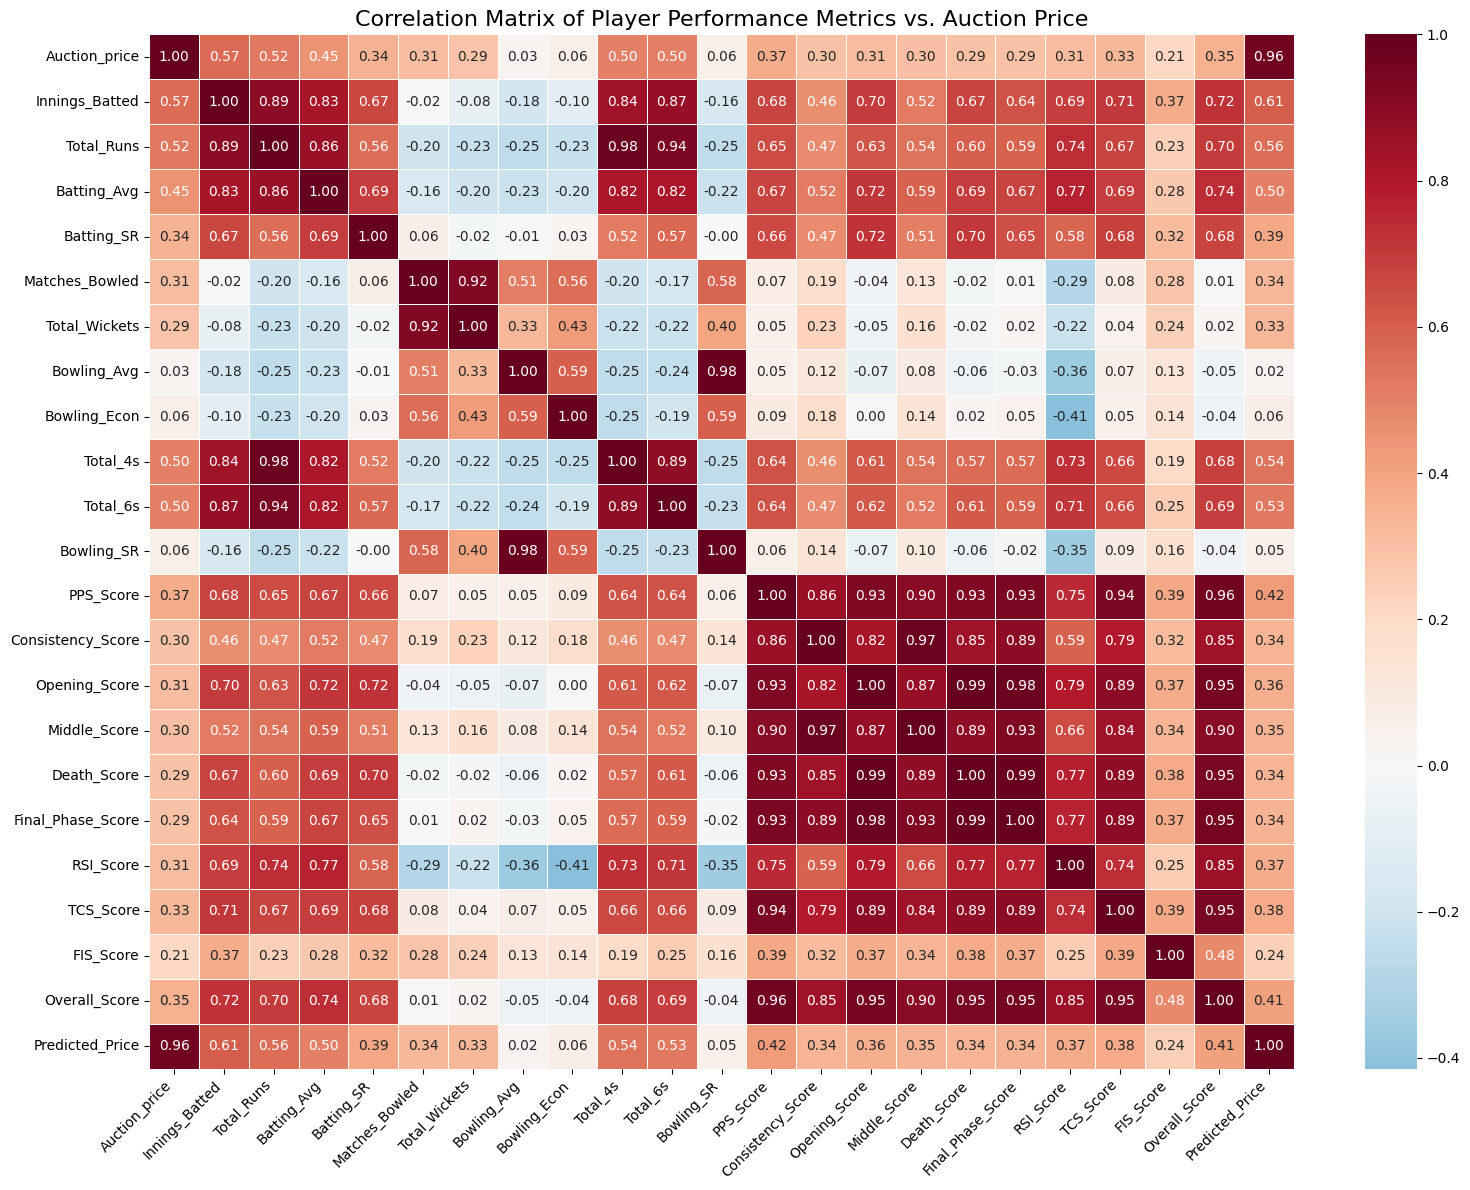


Top Correlations with Auction Price:
Auction_price        1.000000
Predicted_Price      0.963898
Innings_Batted       0.565797
Total_Runs           0.524827
Total_6s             0.498177
Total_4s             0.498049
Batting_Avg          0.449472
PPS_Score            0.366712
Overall_Score        0.354734
Batting_SR           0.343951
TCS_Score            0.328653
RSI_Score            0.312074
Opening_Score        0.310626
Matches_Bowled       0.306765
Middle_Score         0.302760
Consistency_Score    0.296737
Death_Score          0.293314
Final_Phase_Score    0.292502
Total_Wickets        0.286197
FIS_Score            0.209061
Bowling_Econ         0.059826
Bowling_SR           0.056550
Bowling_Avg          0.031527
Name: Auction_price, dtype: float64


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DATA CLEANING (Per your earlier instructions) ---
# Fill numeric attributes with 0 and categorical with ffill
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)

cat_cols = df.select_dtypes(exclude=[np.number]).columns
df[cat_cols] = df[cat_cols].ffill()

# --- 2. GENERATE CORRELATION MATRIX ---
# We exclude 'Player_id' as it is a numeric identifier and not a performance metric
cols_to_exclude = ['Player_id']
numeric_data = df[num_cols].drop(columns=[col for col in cols_to_exclude if col in num_cols])

# Calculate the correlation
corr_matrix = numeric_data.corr()

# --- 3. VISUALIZATION ---
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='RdBu_r', # Red for positive correlation, Blue for negative
            fmt=".2f", 
            linewidths=0.5,
            center=0)

plt.title('Correlation Matrix of Player Performance Metrics vs. Auction Price', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display or Save the heatmap
plt.savefig('correlation_matrix.png')
plt.show()

# Optional: Print the top correlations with Auction_price
if 'Auction_price' in corr_matrix.columns:
    print("\nTop Correlations with Auction Price:")
    print(corr_matrix['Auction_price'].sort_values(ascending=False))

In [ ]:
# ==========================================
# 




# ==========================================
# 1. VISUAL SETTING & BINNING
# ==========================================
set_config(display='diagram')

def manual_bin_score(score):
    if score >= 80:
        return 'Very High'
    elif score >= 60:
        return 'High'
    elif score >= 40:
        return 'Medium'
    else:
        return 'Low'

df['Overall_Score_Grade'] = df['Overall_Score'].apply(manual_bin_score)


# ==========================================
# 2. LEVEL WEIGHT
# ==========================================
level_weight_map = {
    'Uncapped': 1,
    'Capped': 2,
    'Elite': 8
}

df['Level_Weight'] = df['Level'].map(level_weight_map)


# ==========================================
# 3. EMPTY COLUMN FOR PREDICTIONS
# ==========================================
df['Predicted_Price'] = np.nan


# ==========================================
# 4. MODELING BY ROLE (SEPARATE BLOCKS)
# ==========================================
for role in df['Role'].unique():

    subset = df[df['Role'] == role].copy()
    if len(subset) < 5:
        continue

    # Feature selection
    if role == 'Batter':
        num_feats = ['Batting_Avg', 'Batting_SR', 'Total_Runs', 'Total_4s', 'Total_6s']
    elif role == 'Bowler':
        num_feats = ['Bowling_Avg', 'Bowling_Econ', 'Total_Wickets', 'Bowling_SR']
    else:
        num_feats = ['Batting_Avg', 'Batting_SR', 'Bowling_Avg', 'Bowling_Econ']

    cat_feats = ['Level']

    # Preprocessing
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats),
        ('num', 'passthrough', num_feats)
    ])

    # Stacking Ensemble
    model = StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('xgb', XGBRegressor(n_estimators=100, random_state=42))
        ],
        final_estimator=RidgeCV()
    )

    pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])

    # Train
    pipeline.fit(subset[num_feats + cat_feats], subset['Auction_price'])

    # Predict
    preds = pipeline.predict(subset[num_feats + cat_feats])
    df.loc[df['Role'] == role, 'Predicted_Price'] = preds

    # Display pipeline
    print(f"\nPipeline for {role}")
    display(pipeline)

    # Evaluation
    mae = mean_absolute_error(subset['Auction_price'], preds)
    r2 = r2_score(subset['Auction_price'], preds)

    print(f"{role} MAE: {mae:.2f}")
    print(f"{role} R2 : {r2:.2f}")

    print("\nBin Distribution Check")
    print(classification_report(
        subset['Overall_Score_Grade'],
        subset['Overall_Score_Grade']
    ))


# ==========================================
# 5. PRICE IMPACT RATIO CALCULATION
# ==========================================
df['Composite_Score_Adjusted'] = df['Overall_Score'] * df['Level_Weight']

df['Price_Impact_Actual'] = df['Auction_price'] / df['Composite_Score_Adjusted']
df['Price_Impact_Predicted'] = df['Predicted_Price'] / df['Composite_Score_Adjusted']


# ==========================================
# 6. FINAL OUTPUT
# ==========================================
final_df = df[
    [
        'Player_name',
        'Level',
        'Role',
        'Overall_Score',
        'PPS_Score',
        'Consistency_Score',
        'Opening_Score',
        'Middle_Score',
        'Death_Score',
        'Final_Phase_Score',
        'RSI_Score','TCS_Score','FIS_Score',
        'Auction_price',
        'Predicted_Price',
        'Price_Impact_Actual',
        'Price_Impact_Predicted',
        'Overall_Score_Grade'
    ]
]

print("\nFinal Output Preview")
print(final_df.head(10))


# ==========================================
# 7. SAVE FILE
# ==========================================
final_df.to_csv("final_output.csv", index=False)

print("\n✅ final_output.csv saved successfully")



Pipeline for Batter


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Level']),
                                                 ('num', 'passthrough',
                                                  ['Batting_Avg', 'Batting_SR',
                                                   'Total_Runs', 'Total_4s',
                                                   'Total_6s'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RidgeCV()))])

Batter MAE: 177.31
Batter R2 : 0.83

Bin Distribution Check
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        29
         Low       1.00      1.00      1.00         6
      Medium       1.00      1.00      1.00         5
   Very High       1.00      1.00      1.00         7

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47


Pipeline for Wicket Keeper


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Level']),
                                                 ('num', 'passthrough',
                                                  ['Batting_Avg', 'Batting_SR',
                                                   'Bowling_Avg',
                                                   'Bowling_Econ'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsa...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RidgeCV()))])

Wicket Keeper MAE: 233.97
Wicket Keeper R2 : 0.85

Bin Distribution Check
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        13
         Low       1.00      1.00      1.00        12
      Medium       1.00      1.00      1.00         5
   Very High       1.00      1.00      1.00         5

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35


Pipeline for All Rounder


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Level']),
                                                 ('num', 'passthrough',
                                                  ['Batting_Avg', 'Batting_SR',
                                                   'Bowling_Avg',
                                                   'Bowling_Econ'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsa...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RidgeCV()))])

All Rounder MAE: 98.07
All Rounder R2 : 0.93

Bin Distribution Check
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        14
         Low       1.00      1.00      1.00        22
      Medium       1.00      1.00      1.00        36
   Very High       1.00      1.00      1.00         1

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73


Pipeline for Bowler


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Level']),
                                                 ('num', 'passthrough',
                                                  ['Bowling_Avg',
                                                   'Bowling_Econ',
                                                   'Total_Wickets',
                                                   'Bowling_SR'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             col...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RidgeCV()))])

Bowler MAE: 78.45
Bowler R2 : 0.96

Bin Distribution Check
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       1.00      1.00      1.00        19
      Medium       1.00      1.00      1.00        70

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91



KeyError: "['FIS_ScoreAuction_price'] not in index"

In [ ]:
final_df.head()

,Player_name,Level,Role,Overall_Score,Auction_price,Predicted_Price,Price_Impact_Actual,Price_Impact_Predicted,Overall_Score_Grade
0,Vaibhav Suryavanshi,Uncapped,Batter,99.24,110,190.929805,1.108424,1.923920,Very High
1,Ayush Mhatre,Uncapped,Batter,98.50,30,154.222416,0.304569,1.565710,Very High
2,Priyansh Arya,Uncapped,Batter,91.71,380,436.233692,4.143496,4.756664,Very High
3,Urvil Patel,Uncapped,Wicket Keeper,90.12,30,430.905915,0.332889,4.781468,Very High
4,Abishek Porel,Uncapped,Wicket Keeper,87.82,400,566.052983,4.554771,6.445604,Very High


In [ ]:
# 1. Define the weights based on your requirements
level_weights = {
    'Uncapped': 1,
    'Capped': 2,
    'Elite': 7
}

# 2. Map these weights to a temporary column for calculation
final_df['Level_Weight'] = final_df['Level'].map(level_weights)

# 3. Calculate Price Impact for both Actual and Predicted values
# Formula: Price / (Overall_Score * Level_Weight)
final_df['Price_Impact_Actual'] = final_df['Auction_price'] / (final_df['Overall_Score'] * final_df['Level_Weight'])
final_df['Price_Impact_Predicted'] = final_df['Predicted_Price'] / (final_df['Overall_Score'] * final_df['Level_Weight'])

# 4. Display the Final Report


print(final_df.head(10))

           Player_name     Level           Role  Overall_Score  Auction_price  \
0  Vaibhav Suryavanshi  Uncapped         Batter          99.24            110   
1         Ayush Mhatre  Uncapped         Batter          98.50             30   
2        Priyansh Arya  Uncapped         Batter          91.71            380   
3          Urvil Patel  Uncapped  Wicket Keeper          90.12             30   
4        Abishek Porel  Uncapped  Wicket Keeper          87.82            400   
5         Aniket Verma  Uncapped         Batter          87.51             30   
6       Mitchell Marsh    capped    All Rounder          86.64            340   
7        Dewald Brevis    capped         Batter          84.61            220   
8     Yashasvi Jaiswal    capped         Batter          84.06           1800   
9        Sai Sudharsan    capped         Batter          82.76            850   

   Predicted_Price  Price_Impact_Actual  Price_Impact_Predicted  \
0       190.929805             1.108424  

C:\Users\yogya\AppData\Local\Temp\ipykernel_4920\1444717100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Level_Weight'] = final_df['Level'].map(level_weights)
C:\Users\yogya\AppData\Local\Temp\ipykernel_4920\1444717100.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Price_Impact_Actual'] = final_df['Auction_price'] / (final_df['Overall_Score'] * final_df['Level_Weight'])
C:\Users\yogya\AppData\Local\Temp\ipykernel_4920\1444717100.py:14: SettingWithCopyWarning: 
A value is try

In [ ]:
import pandas as pd
from sklearn import set_config
from IPython.display import display
from sklearn.metrics import classification_report

# 1. VISUAL SETTING
set_config(display='diagram')

# 2. STRING NORMALIZATION & WEIGHT MAPPING
# Convert to lower case and strip whitespace to ensure perfect matching
final_df['Level'] = final_df['Level'].str.lower().str.strip()

# Define weights with lowercase keys to match the transformed data
level_weights = {
    'uncapped': 1,
    'capped': 2,
    'elite': 7
}

# Map weights for calculation
final_df['Level_Weight'] = final_df['Level'].map(level_weights)

# 3. CALCULATE PRICE IMPACT RATIOS
# Formula: Price / (Overall_Score * Level_Weight)
final_df['Price_Impact_Actual'] = final_df['Auction_price'] / \
                                  (final_df['Overall_Score'] * final_df['Level_Weight'])

final_df['Price_Impact_Predicted'] = final_df['Predicted_Price'] / \
                                     (final_df['Overall_Score'] * final_df['Level_Weight'])

# 4. EVALUATION & CLASSIFICATION REPORT
# Displaying how the manual bins categorize the player pool
print("\n--- GLOBAL CLASSIFICATION REPORT (Score Bins) ---")
print(classification_report(final_df['Overall_Score_Grade'], final_df['Overall_Score_Grade']))

# 5. DISPLAY FINAL REPORT
report_cols = [
    'Player_name', 'Level', 'Role', 'Auction_price', 
    'Predicted_Price', 'Price_Impact_Actual', 'Price_Impact_Predicted', 'Overall_Score_Grade'
]

print("\n--- FINAL PLAYER ANALYSIS REPORT ---")
print(final_df[report_cols].head(10))


--- GLOBAL CLASSIFICATION REPORT (Score Bins) ---
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        58
         Low       1.00      1.00      1.00        59
      Medium       1.00      1.00      1.00       116
   Very High       1.00      1.00      1.00        13

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246


--- FINAL PLAYER ANALYSIS REPORT ---
           Player_name     Level           Role  Auction_price  \
0  Vaibhav Suryavanshi  uncapped         Batter            110   
1         Ayush Mhatre  uncapped         Batter             30   
2        Priyansh Arya  uncapped         Batter            380   
3          Urvil Patel  uncapped  Wicket Keeper             30   
4        Abishek Porel  uncapped  Wicket Keeper            400   
5         Aniket Verma  uncapped         Batter             30   
6       Mitche

C:\Users\yogya\AppData\Local\Temp\ipykernel_4920\1379414031.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Level'] = final_df['Level'].str.lower().str.strip()
C:\Users\yogya\AppData\Local\Temp\ipykernel_4920\1379414031.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Level_Weight'] = final_df['Level'].map(level_weights)
C:\Users\yogya\AppData\Local\Temp\ipykernel_4920\1379414031.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

<AxesSubplot: >

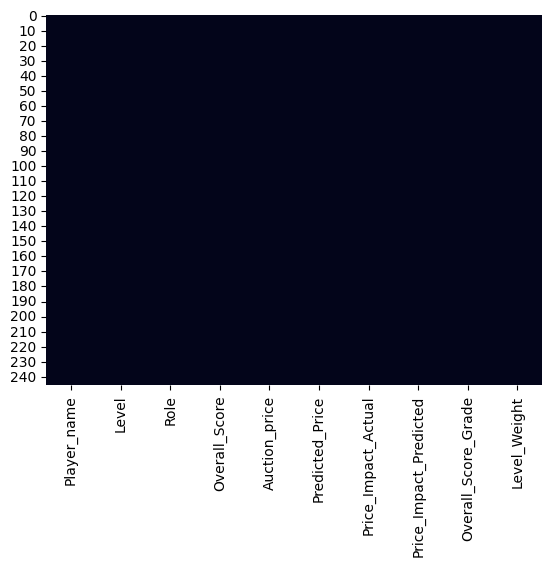

In [ ]:
import seaborn as sns
sns.heatmap(final_df.isnull(), cbar=False)

In [ ]:
final_df.to_csv("final_output_with_price_impact.csv", index=False)